In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os

from src.passey_model_core import  run_passey_inverse_model
from src.plotting_tools import  plot_inverse_model_results, plot_seasonal_model, analyze_and_save_horse_plot

# Load data

In [3]:
data=pd.read_csv('data/equus_alldata.csv',delimiter=';')
data=data[[c for c in data.columns if c[:2]!='Un']].dropna()
for c in data.columns:
  try:
    data[c]=data[c].str.replace(',','.').astype(float)
  except:
    pass
data[['horse','index_tooth']]=data.nom_sample.str.split(' ',expand=True)
data['index_tooth']=data['index_tooth'].str.replace('bis','').astype(int)
data.sample(5)

,nom_sample,dent,hauteur_sample,d13CVPDB_COR,d13C/12C_SD,d18OVPD_COR,d18O/16O _SD,d18Ovsmow,predicted_phosphate_Iacumin1996,horse,index_tooth
28,R-7734_M3 13,M3,25.18,-10.874250,0.009,-4.733500,0.019,26.030188,17.009584,R-7734_M3,13
268,Fritsch_LR8_equus 2,nd,58.00,-10.141833,0.019,-4.773500,0.042,25.988951,16.969172,Fritsch_LR8_equus,2
223,Fritsch_LR5_eq 1,nd,57.63,-11.126900,0.014,-4.338900,0.038,26.436985,17.408245,Fritsch_LR5_eq,1
105,P.IV0_M101-13_M2 5,M2,66.47,-11.307857,0.010,-7.113714,0.030,23.576401,14.604873,P.IV0_M101-13_M2,5
18,R-7734_M3 3,M3,54.57,-11.073250,0.018,-4.632500,0.024,26.134309,17.111623,R-7734_M3,3


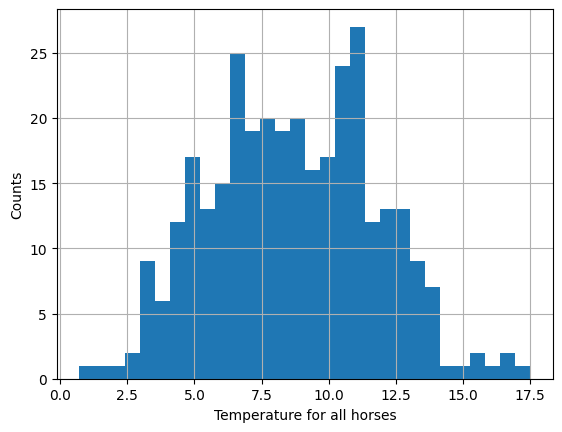

In [4]:
list_horses=data.horse.unique()
#Following the equations that relate d18O of phosphate to d18O of water and then to temperature
#from ???
data['d18Ovsmow']=(data['d18OVPD_COR']*1.03091+30.91)
data['O18phosphate']=data['d18Ovsmow']*0.98-8.5
data['enamel']=data['O18phosphate']
data['d18Oprecipitation']=data['enamel']*1.4-31.72
data['temperature']=(data['d18Oprecipitation']+13.74)/0.53
data["temperature"].hist(bins=30)
plt.xlabel('Temperature for all horses');
plt.ylabel('Counts');

# Results

## Single horse

In [5]:
horse_name=list_horses[3]

horse_df=data.loc[data.horse==horse_name].sort_values(by='index_tooth').copy()
horse_df['depth']=10.5
horse_df['length']=horse_df['hauteur_sample'].diff(-1)*10
horse_df=horse_df.dropna()
horse_df.head(5)

,nom_sample,dent,hauteur_sample,d13CVPDB_COR,d13C/12C_SD,d18OVPD_COR,d18O/16O _SD,d18Ovsmow,predicted_phosphate_Iacumin1996,horse,index_tooth,O18phosphate,enamel,d18Oprecipitation,temperature,depth,length
53,R_5378_P3/4 1,P3/4,61.40,-10.480286,0.018,-5.726286,0.027,25.006715,16.006580,R_5378_P3/4,1,16.006580,16.006580,-9.310787,8.357005,10.5,31.6
54,R_5378_P3/4 2,P3/4,58.24,-10.717286,0.018,-5.050286,0.023,25.703610,16.689538,R_5378_P3/4,2,16.689538,16.689538,-8.354647,10.161043,10.5,36.7
55,R_5378_P3/4 3,P3/4,54.57,-10.807286,0.010,-5.079286,0.018,25.673714,16.660239,R_5378_P3/4,3,16.660239,16.660239,-8.395665,10.083651,10.5,33.9
56,R_5378_P3/4 4,P3/4,51.18,-10.938286,0.016,-4.613286,0.014,26.154118,17.131035,R_5378_P3/4,4,17.131035,17.131035,-7.736551,11.327263,10.5,39.0
57,R_5378_P3/4 5,P3/4,47.28,-11.068286,0.021,-4.107286,0.032,26.675758,17.642243,R_5378_P3/4,5,17.642243,17.642243,-7.020860,12.677623,10.5,35.5


In [6]:
measurements = horse_df['temperature'].to_numpy(dtype=float)
segment_lengths = horse_df['length'].to_numpy(dtype=int)
sampling_depths = horse_df['depth'].to_numpy(dtype=int)

estimated_matrix = run_passey_inverse_model(
    measurements=measurements,
    segment_lengths=segment_lengths,
    sampling_depths=sampling_depths,
    num_trials=100,
    analysis_error_std=0.3,
    length_error_std=1.0,
    depth_error_std=2.0,
    lag_depth=15,
    mixing_length=250,
    min_length=3,
    max_length=40,
    min_depth=5,
    open_ended_index=1,
    initial_fraction=0.25,
    verbose=True
)

Step 1/3: Computing mean baseline error (Edist)...
Step 2/3: Finding optimal regularization factor (df)...


Running simulations: 100%|██████████| 100/100 [00:02<00:00, 47.04it/s]


Step 3/3: Running final inverse prediction...


Running predictions: 100%|██████████| 100/100 [00:02<00:00, 49.61it/s]

Inverse modeling complete.


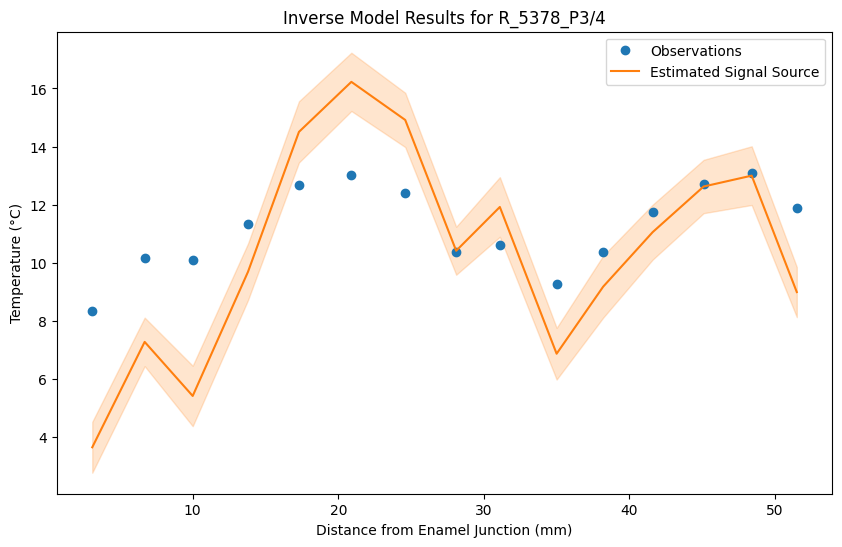

In [7]:
plt.figure(figsize=(10, 6)) 
plot_inverse_model_results(
    segment_lengths=segment_lengths,
    measurements=measurements,
    estimated_matrix=estimated_matrix,
    title_label=horse_name
)
plt.show()

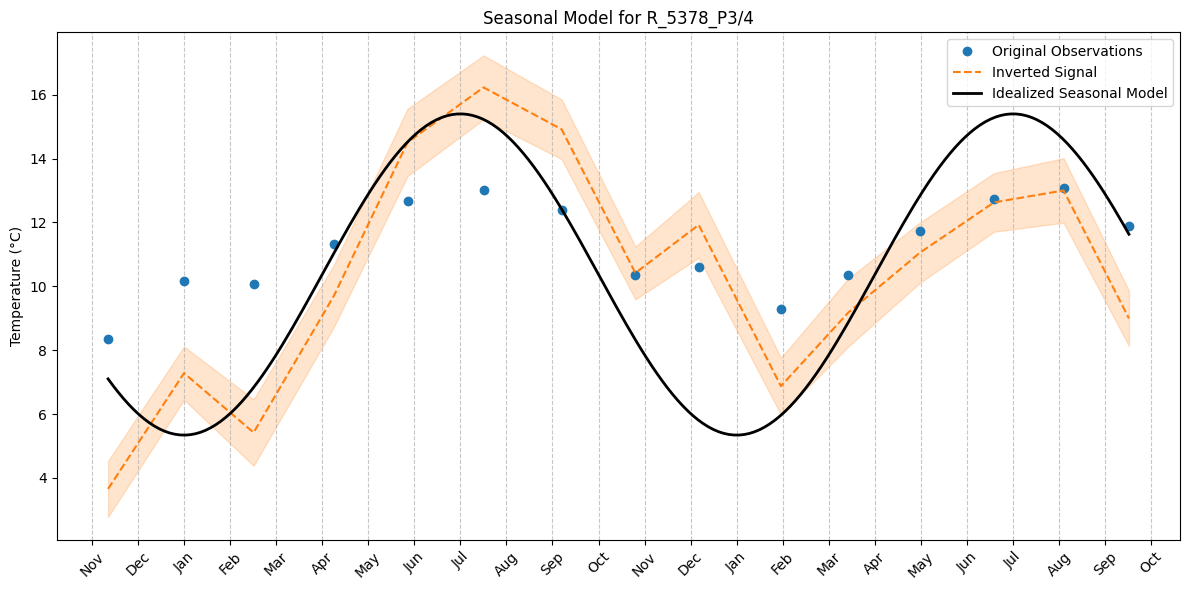

In [8]:
#from src.curve_fitting_tools import plot_seasonal_model

# 1. Prepare the data for the function.
x = np.cumsum(segment_lengths) / 10  # Distance axis in mm
y = np.mean(estimated_matrix, 0)     # Mean inverted signal
y_std = np.std(estimated_matrix, 0)  # Standard deviation of the signal

# 2. Call the new function to generate the plot.
plot_seasonal_model(
    x_distance=x,
    measurements=measurements,
    estimated_signal=y,
    estimated_std=y_std,
    title_label=horse_name
)
plt.show()

## All horses

In [ ]:
output_directory = 'data/results'
os.makedirs(output_directory, exist_ok=True)

for horse in tqdm(list_horses):
    analyze_and_save_horse_plot(data, horse, output_directory)

print("\nAnalysis complete for all horses.")

100%|██████████| 19/19 [01:27<00:00,  4.58s/it]


Analysis complete for all horses.
